# Analyzing ratings data in a Bayesian Framework

The Problem: Suppose you go to Amazon in search of a book on Bayesian statistics and enter "Bayesian statistics" as your search query. You obviously want the best book, so you go and sort by average rating. The result is a bunch of books with relatively few ratings, all of which are very high.

![](search_results.png)

Now I'm sure that these are all great books, but the issue is that there aren't enough ratings to give a good estimate of what the *true* average rating is for each of these books. 

The fix: We can use Bayesian data analysis to incorporate the lack of information and uncertainty into our estimate of the true mean.

The inspuration: I saw Erk Bernhardsson's post [*Analyzing a small dataset with 1-5 ratings*](https://erikbern.com/2015/12/05/more-mcmc-analyzing-a-small-dataset-with-1-5-ratings/) and thought I would expand on it and show another example.
Note that the code appears to be missing from his post.

But let's take a step back, introduce Bayesian inference, do a simple example, and then apply what we've learned to the problem at hand.

## A quick introduction to Bayesian inference

Note: This really quick introduction to Bayesian data analysis will roughly follow and occasionally borrow material from [Bayesian Data Analysis](http://www.stat.columbia.edu/~gelman/book/) by Andrew Gelman, John Carlin, Hal Stern, David Dunson, Aki Vehtari, and Donald Rubin.
Any unattributed quotes are from this book.

### What is Bayesian inference?

Well first, what is statistical inference?
Statistical inference is the process of determining the parameters of an underlying probability distribution based on some data.
So, for example, given sex data on a bunch of births, can we estimate the true probability of a male or female birth?

Bayesian inerence, then, is using [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem) to perform statistical inference.
From Gelman, et al:
> Bayesian inference is the process of fitting a probability model to a set of data and summarizing the result by a probability distribution on the parameters of the model and on unobserved quantities such as predictions for new observations. 

### Traditional and Bayesian inference example
#### Traditional Inference method

Let's continue with the example of male and female births from above.
In the 18th century Laplace attempted to estimate the female birth rate in Paris.
He found that 241,945 girls and 251,527 boys were born in Paris between 1745 and 1770.

Using traditional inference methods first, let's estimate what the true proportion of female births in Paris is.
We assume that the birth data is drawn from a [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution), which is a "discrete probability distribution of the number of successes in a sequence of $n$ independent yes/no experiments, each of which yields success with probability $p$."

The estimate for the proportion is just the ratio of female briths to total births.

$$\hat{p} = \frac{\text{# girl births}}{\text{# total births}} = \frac{241,945}{241,945+251,527} \approx 0.490$$

How certain are we of this estimate though?
How wide is the range of values that the true number of births could take on?
To answer these questions we need to compute a confidence interval and perform a statistical hypothesis test.

Let's start with a hypothesis test for the true parameter $p$ to see if it is statistically different from $\frac{1}{2}$.
[//]: # (http://stats.stackexchange.com/questions/113602/test-if-two-binomial-distributions-are-statistically-different-from-each-other)
To perform a hypothesis test for a binomial proportion we first need a null hypothesis $H_0$.
Our null hypothesis is of course that the true birth rate for females is the same as that of males, i.e. $H_0: \hat{p}=p_0 = 0.5$.
Our alternative hypothesis is that the birth rates are not equal, i.e. $H_A: \hat{p} \ne p_0$.

The test statistic that we need is a one-proportion z-test:

$$
z = \frac{\hat{p} - p_0}{\sqrt{p_0(1-p_0)}}\sqrt{n}.
$$

Plugging in:

In [1]:
from math import sqrt

def one_prop_z(p_hat, p_0, n):
    z = (p_hat - p_0)/sqrt(p_0*(1-p_0))*(sqrt(n))
    return z

female_births = 241945
male_births = 251527
n = female_births + male_births
p_hat = female_births/n

print(one_prop_z(p_hat, 0.5, n))

-13.640330988151018


Since our computed z-score is -13.6 < -1.96, we can reject the null hypothesis and conclude that the true proportion is not $0.5$.

Now let's compute a [binomial proportion confidence interval](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval).
We have a lot of data so we don't need to compute the Wilson score interval and can use the normal approximation, but let's do both.

Aside: For those of you familiar with reddit, their "best" ranking uses the lower bound of the Wilson score confidence interval of upvotes and downvotes to get a pessimistic estimate of the true upvote and downvote ratio of the link. This keeps links with just one upvote from being ranked highly, even though the score is basically perfect. You can see the code [here](https://github.com/reddit/reddit/blob/master/r2/r2/lib/db/_sorts.pyx). The "hot" ranking is pretty neat too.

The Wilson score interval is given by
$$
\frac{1}{1 + \frac{1}{n} z^2}
  \left[
    \hat{p} + \frac{1}{2n} z^2 \pm
    z \sqrt{
      \frac{1}{n}\hat{p} \left(1 - \hat{p}\right) +
      \frac{1}{4n^2}z^2
    } 
   \right]
$$
where $z$ is the z-score for the $1-\frac{1}{2}\alpha$ quantile of the standard normal distribution. In our case, we'll compute a 95% conifdence interval, so $\alpha = 0.05$ and $z=1.96$.

The normal approximation interval is 
$$
\hat{p} \pm z\sqrt{\frac{1}{n}\hat{p}(1-\hat{p})}.
$$

Let's compute them.

In [2]:
from math import sqrt

def wilson_score_interval(p_hat, n, z):
    pm = z*sqrt(p_hat*(1-p_hat)/n + z**2/(4*n**2))
    inner = p_hat + z**2/(2*n)
    outer =(1/(1+z**2/n))
    lower_bound = outer*(inner - pm)
    upper_bound = outer*(inner + pm)
    return lower_bound, upper_bound

def normal_approx_interval(p_hat, n, z):
    right = sqrt(p_hat*(1-p_hat)/n)
    lower = p_hat - right
    upper = p_hat + right
    return lower, upper

female_births = 241945
male_births = 251527
z = 1.96
n = female_births + male_births
p_hat = female_births/n

print("Wilson score interval: {}".format(wilson_score_interval(p_hat, n, z)))
print("Normal approx interval: {}".format(normal_approx_interval(p_hat, n, z)))





Wilson score interval: (0.4888965202876094, 0.4916861157965965)
Normal approx interval: (0.4895796081852655, 0.49100287673789117)


We see that the normal approximation interval and the Wilson score interval are very close, and that neither contain $0.5$. This confirms that the true proportion is very likely not 0.5, but is in fact lower.

#### Bayesian Inference method

Now we are going to do estimate the true proportion of male and female births using Bayesian inference.
Bayes' rule tells us that we can compute the distribution of the paramater conditional on the data in the following way:

Let $\theta$ be the parameter (or parameters) of interest and let $y$ be the data that's been collected. 
We assume that the data comes from a distribution condiitional on $\theta$ $p(y|\theta)$.
This is called the *likelihood* or the *sampling distribution*.
We assume further that the parameter is a random variable from another distribution $p(\theta)$ called the *prior*.
The prior represents our prior (before looking at our data) beliefs about the parameters. 
Note that while we used $p$ for both the likelihood and the prior, that $p$ is in fact two different distributions distinguished by the parameters.
It is an abuse of notation for convenience and the different parameters of each distribution indicate to the reader that they are different.
Using $p(y|\theta)$ and $p(\theta)$ we have
$$
p(\theta,y) = p(y,\theta) = p(y|\theta)p(\theta)
$$
If we have also the marginal distribtution of $y$, 
$$p(y) = \int p(y,\theta)d\theta = \int p(y|\theta)p(\theta)d\theta.
$$
then we can compute the distribution for $\theta$ conditional upon $y$ simply by conditioning the joint $p(\theta,y)$ on $y$.
Concretely,
$$
p(\theta|y) = \frac{p(y|\theta)p(\theta)}{p(y)},
$$
which is precisely the distribution of the parameter conditional upon the data, called the *posterior distribution* that we were seeking.

However, since we are looking for $p(\theta|y)$ as a function of $\theta$, and since the marginal distribution of $y$ does not depend on $\theta$, we also have
$$
p(\theta|y) \propto p(y|\theta)p(\theta).
$$
Essentially, $p(y)$ is constant so we can compute an unnormalized density function to avoid having to marginalize.
This makes our lives easier and only puts us off the true posterior distribution by a constant factor.

Back to trying to compute the true population birth proportion.
Just as before, we assume that the data is sampled from a binomial distribution with unknown proportion parameter $p$, which we are going to relabel as $q$ since we are going to use $p$ for all of our pdfs.
Let $g$ be the number of girls born and $n$ be the total number of births. Our likeihood pdf is then $p(g|q,n) = {n \choose g} q^g(1-q)^{n-g}$.

Now we need a prior which means we have to make a choice.
How do we choose a prior? 
This [stats.se answer](http://stats.stackexchange.com/questions/78606/how-to-choose-prior-in-bayesian-parameter-estimation) gives a good overview. If you have access to *Introduction to Bayesian Statistics* by William M. Bolstad, there is an excellent discussion on choosing a prior for a binomial likelihood in section 8.3.

We are actually going to do the analysis with two different choices of prior, a uniform (Laplace's choice) and a beta distribution ([conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior)).

First the uniform prior.

* Likelihood: $p(g|q,n) = {n \choose g} q^g(1-q)^{n-g}$
* Prior: $p(q|n) = 1$

This gives:

* Posterior: $p(q|g,n) \propto p(g|q,n)p(q|n) = {n \choose g} q^g(1-q)^{n-g} \times 1 = {n \choose g} q^g(1-q)^{n-g}$

Now, even without know the constant of proportionality, we can recognize $p(q|g,n)$ as a [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution)!
That means we actually have the full, normalized distribution without having to compute marginal of $g$.

* Posterior: $p(q|g,n) = \frac{p(g|q,n)p(q|n)}{p(g|n)} =  \frac{q^g(1-q)^{n-g}}{B(g+1,n-g+1)}$

where $B$ is the [beta function](https://en.wikipedia.org/wiki/Beta_function).

In other words, $q|g,n \sim Beta(g+1,n-g+1)$.

Using this we can get compute a credible interval, which is the Bayesian analog to a confidence interval.

In [3]:
from scipy.stats import beta

print(beta.ppf(0.025, 241945+1,251527+1))
print(beta.ppf(0.975, 241945+1,251527+1))

0.48889654636
0.491686091798


You'll notice that this is pretty much exactly what we got from the frequentist confidence interval.
The key difference for us here is the interpretation of what this interval means.
[Jake VanderPlas says it better than I ever could](http://jakevdp.github.io/blog/2014/06/12/frequentism-and-bayesianism-3-confidence-credibility/): 

>The above derivation is one reason why the frequentist confidence interval and the Bayesian credible region are so often confused. In many simple problems, they correspond exactly. But we must be clear that even though the two are numerically equivalent, their interpretation is very different.

>Recall that in Bayesianism, the probability distributions reflect our degree of belief. So when we computed the credible region above, it's equivalent to saying

>>"Given our observed data, there is a 95% probability that the true value of μ falls within CRμ" - Bayesians

>In frequentism, on the other hand, μμ is considered a fixed value and the data (and all quantities derived from the data, including the bounds of the confidence interval) are random variables. So the frequentist confidence interval is equivalent to saying

>>"There is a 95% probability that when I compute CIμ from data of this sort, the true mean will fall within CIμ." - Frequentists

>Note the difference: the Bayesian solution is a statement of probability about the parameter value given fixed bounds. The frequentist solution is a probability about the bounds given a fixed parameter value. This follows directly from the philosophical definitions of probability that the two approaches are based on.

Now for the Beta prior. In this case we are going to use Beta(1/2,1/2) which is the [Jeffreys Prior](https://en.wikipedia.org/wiki/Jeffreys_prior). Even though this type of prior appears in [Yang and Berger's "A Catalog of Noninformative Priors" (pdf link)](http://www.stats.org.uk/priors/noninformative/YangBerger1998.pdf) it is not really a noninformative prior.

As Bolstad says:
>If we think of the parameter as an index of all possible densities the observation could come from, then any continuous function of the parameter would give an equally valid index. Jeffreys' method gives a pries that is invariant under any continuous transformation of the parameter. That means that Jeffreys' prior is objective in the sense that it does not depend on the particular parameterization we used. **However, for most parameterizations, the Jeffreys' prior gives more weight to some values than to others so it is usually informative, not noninformative.**

* Likelihood: $p(g|q,n) = {n \choose g} q^g(1-q)^{n-g}$
* Prior: $p(q|n) = \frac{q^{-1/2}(1-q)^{-1/2}}{B(1/2,1/2)}$

This gives:

* Posterior: $p(q|g,n) \propto p(g|q,n)p(q|n) = {n \choose g} q^g(1-q)^{n-g} \times \frac{q^{-1/2}(1-q)^{-1/2}}{B(1/2,1/2)} = {n \choose g} \frac{q^g(q-1/2)^{n-g-1/2}}{B(1/2,1/2)} = Beta(g+1/2, n-g+1/2)$


Actually computing it, we get:

In [4]:
from scipy.stats import beta

print(beta.ppf(0.025, 241945+1/2,251527+1/2))
print(beta.ppf(0.975, 241945+1/2,251527+1/2))

0.488896525274
0.491686073536


This is different, but not really.
Neither of the priors make a huge difference because we have a preponderance of data.

What if we don't want to do a bunch of algebra and comparing our distribution to known ones?
We can simulate random draws from the posterior distribution without knowing what it is explicitly.
This is useful for when our likelihood and our prior aren't so simple and compitable, and the posterior is consequently an ugly mess that isn't a known or well studied probability distribution.
Using these draws from the posterior, we can get a Bayesion credibility interval by simply computing the middle 95% of the data.

The following code shows how to do this.

 [-----------------100%-----------------] 500000 of 500000 complete in 21.5 sec

/Users/keith/.virtualenvs/notebooks/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


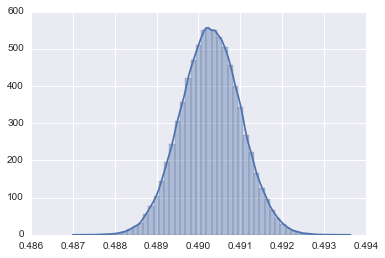

(0.48889381223922224, 0.4916867923137298)


In [5]:
from pymc import *
import seaborn as sns
import numpy as np
%matplotlib inline

female_births = 241945
male_births = 251527
n = female_births + male_births

prior = Uniform('prior', 0.0, 1.0)
likelihood = Binomial('likelihood', n=n, p=prior, value=female_births, observed=True)
model = Model([prior, likelihood])
prior.value = 0.5
#print(model.logp)

mc = MCMC(model)
mc.sample(iter=500000,burn=10000)
sns.distplot(prior.trace())
sns.plt.show()

print("({}, {})".format(np.percentile(prior.trace(), 2.5), np.percentile(prior.trace(), 97.5)))

Again, we see that the interval is essentially the same. 
This method of simulating draws from the posterior is called [Markov chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) and is very general and very powerful.
However, it may generate slow convergence.
You'll notice we used 500,000 samples from the posterior to generate, but this may be unnecessary and there are [some diagnostics](https://pymc-devs.github.io/pymc/modelchecking.html) to discern whether the simulation has converged.

## Back to our original problem with 1-5 ratings.

Obviously the binomial distribution we used just before is not appropriate since it only models yes/no 1/0 type problems.
What we need is a [multinomial distribution](https://en.wikipedia.org/wiki/Multinomial_distribution), which, as that Wikipedia link states, is
>a generalization of the binomial distribution. For example it models the probability of counts for rolling a k sided die n times. For n independent trials each of which leads to a success for exactly one of k categories, with each category having a given fixed success probability, the multinomial distribution gives the probability of any particular combination of numbers of successes for the various categories.

This is perfect for the likelihood for our problem.
Let's consider the last book in the picture of the search results above: *Statistical Learning with Sparsity* by Hastie and Tibshirani (only because of the books in the picture, it has the fewest ratings. I'm sure it's a great book as they are two of the authors of the excellent *Elements of Statistical Learning*).
We are going to use a [Dirichlet](https://en.wikipedia.org/wiki/Dirichlet_distribution) prior, which is conjugate to the multinomial distribution.
As the multinomial distribution is a generalization of the binomial, the Dirichlet is a generalization of the beta distribution.

So we have

* Likelihood: $p(\mathbf{r}|\mathbf{p}) \sim \text{Multinomial}(\mathbf{r}|\mathbf{p})$ where $\mathbf{r}$ is our data and $\mathbf{p}$ is such that $\sum_{i=1}^k \mathbf{p}_i = 1$
* Prior: $p(\mathbf{p}|\mathbf{\alpha}) \sim \text{Dirichlet}(\mathbf{p}|\mathbf{\alpha})$
* Prior Hyperparameter: Notice that the prior is dependent on some variable $\mathbf{\alpha}$, which is a prior hyperparameter. In the case of the Dirchlet distribution it is a [pseudocount](https://en.wikipedia.org/wiki/Pseudocount), which means that it represents what we think the distribution of counts might be before hand. We're going to leave it level at all ones. 

This gives:

* Posterior: $p(\mathbf{p}|\mathbf{\alpha},\mathbf{r}) \sim \text{Dirichlet}(\mathbf{p}|\mathbf{\alpha} + \mathbf{r})

So our posterior for $\mathbf{p}$, the probability parameter that controls how likely each rating is, is distributed Dirichlet with a parameter that's a sum of our assumed prior hyperparameter and our data. We can see now why choosing a flat, low info prior was a good idea – it gives a uniform initial distribution, but doesn't affect the result too much once we get some data.

Anyway, using this, we can compute the posterior means analytically to be $(\frac{1}{9},\frac{1}{9},\frac{1}{9},\frac{1}{9},\frac{5}{9})$, which represents our 

In [15]:
from pymc import *
import seaborn as sns
import numpy as np
%matplotlib inline

# of success for each possibility
x = [0,0,0,0,4]
n = sum(x)

prior = Dirichlet(name="prior", theta=[1,1,1,1,1])
likelihood = Multinomial(name='likelihood', value=x, n=n, p=prior, observed=True)
model = Model([prior, likelihood])

mc = MCMC(model)
mc.sample(iter=500000,burn=10000)



print("({}, {})".format(np.percentile(prior.trace(), 0.025), np.percentile(prior.trace(), 0.975)))

 [-----------------100%-----------------] 500000 of 500000 complete in 45.7 sec(4.034906069290672e-05, 0.001224735125482726)


/Users/keith/.virtualenvs/notebooks/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


(0.003010774907922919, 0.380500212706883)
(0.00322203712556267, 0.37820316072720495)
(0.003124093734438364, 0.37575723113970955)
(0.0032067570456246405, 0.37314851535147125)
(0.2412569164556213, 0.8419023666523914)


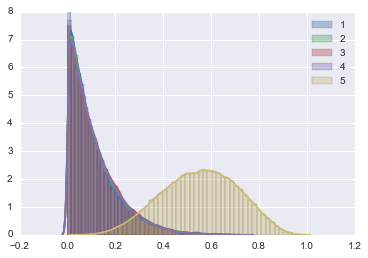

[ 0.10977334  0.11159505  0.11363853  0.1116608   0.55333229]
Average rating estimate is: 3.8871836433290317


In [16]:
import matplotlib.pyplot as plt

a = prior.trace()
b = np.array([1 - a.sum(axis=1)]).T
a = np.append(a,b,1)
for i, label in enumerate(['1', '2', '3', '4', '5']):
    sns.distplot(a[:,i],label=label)
    print("({}, {})".format(np.percentile(a[:,i], 2.5), np.percentile(a[:,i], 97.5)))
plt.legend()
sns.plt.show()
means = np.mean([a[:,i] for i in range(5)],axis=1)
print(means)

score = np.sum((means[i]*(i+1) for i in range(5)))
print("Average rating estimate is: {}".format(score))

So we see that our computed means just about agree with the analytical ones at around $\frac{1}{9}$ for all the ratings except the last one which is $\frac{5}{9}$. 
We use this (or the analytical result) to estimate the true rating for the book to be at around 3.8 stars. Still a good rating, but not the 5 star average it gets otherwise.
We can temper our rating even more by giving more weight in our prior hyperparameters.
Using all tens instead of all ones and the estimate moves to just 3.2 stars.

Ideally, this is what Amazon should be doing when sorting by average rating to account for the uncertainty inherent in the items with only a few ratings.

Note here that if we use the MLE estimate for each of the probabilities (this does not include prior information), we would get $(0,0,0,0,1)$ and again the average rating would be 5.
A trick to get around this is to use a conservative estimate for each value from a simultaneous confidence interval for multinomial proportion.
There are [several different methods](http://rpackages.ianhowson.com/cran/CoinMinD/) for computing these intervals and it can get pretty complicated.

Meanwhile, the analytical expressions for the Bayesian method can be ugly, but as we've seen, we don't need them.
We simply need to be able to simulate from the posterior to get accuarate estimates of the true proportions.

## Conclusion

* We saw that Bayesian inference can be a powerful and very general method for estimating parameters, while still being simple in principle.
* The interpretation of Bayesian confidence intervals, as well as most other results, can be different even though the numbers end up the same.
* We discussed likelihoods, choices of priors (briefly, with references) and posterior distributions.
* We used MCMC, but didn't go into the details of how it works (maybe another time for that).
* More data leads to less variation and less influence from the prior, so when there is a lot of data the Bayesian estimate can be very close to the frequentist one.